### Importing Necessary libraries

We have imported the following libaries with respect to the purpose mentioned:
1. **bs4** : parsing and creating the soup
2. **sqlite3** : to store data and use it effeciently
3. **Pandas**  : Data representation and easier to use with matlotlib
4. **matpotlib** : Data visualization
5. **requests** : Request content from a website on the internet
6. **re** : for string manipulations ( mostly clearing whitepsaces)
7. **Wordcloud** : to generate a wordcloud


In [1]:
# Importing all the libraries
from bs4 import BeautifulSoup, Comment
import re
import requests
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Creating a database

Inititally we create a database with three tables and columns as menitoned below.
Cursor object is used to execute the queries.

In [2]:
# Creating a database and making the relevant tables

conn = sqlite3.connect('Faculty_list.db')
cursor = conn.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS Faculty_iisc_math (
        ID INTEGER PRIMARY KEY NOT NULL,
        Name TEXT,
        Designation TEXT,
        Location_of_PhD TEXT,
        Personal_Website TEXT,
        Email TEXT,
        Research_Interests TEXT,
        Contact_Number TEXT,
        Institute TEXT,
        Department TEXT);''')


cursor.execute('''CREATE TABLE IF NOT EXISTS Faculty_iitb_math (
        ID INTEGER PRIMARY KEY NOT NULL,
        Name TEXT,
        Designation TEXT,
        Location_of_PhD TEXT,
        Personal_Website TEXT,
        Email TEXT,
        Research_Interests TEXT,
        Contact_Number TEXT,
        Institute TEXT,
        Department TEXT);''')

cursor.execute('''CREATE TABLE IF NOT EXISTS Faculty_snbose (
        ID INTEGER PRIMARY KEY NOT NULL,
        Name TEXT,
        Designation TEXT,
        Location_of_PhD TEXT,
        Personal_Website TEXT,
        Email TEXT,
        Research_Interests TEXT,
        Contact_Number TEXT,
        Institute TEXT,
        Department TEXT);''')


conn.commit()
conn.close()

## IISc Mathematics Department extraction

Before proceeding we first check the status_code of the website via

```
request.get('url').status_code()
```
It should return 200

---

- The website was not much troublesome, all data was found int he div tag , class = `col=md-10`.
And all the data was properly labelled with strings and relevant tags.
- The only intresting thing done was to split the PhD location data as shown below, since the the data was in form `(Ph.D., Rutgers)`. The code below removes the brackets and irrelevant information.



In [3]:
# IISc Department of Mathematics

#Creating the soup and requesting the site
iisc_math = requests.get('https://math.iisc.ac.in/faculty.html').text
soup_iisc_math = BeautifulSoup(iisc_math, 'lxml')

# Connecting to the database
conn = sqlite3.connect('Faculty_list.db')

# Extracting the Cards
faculty_members = soup_iisc_math.find_all('div', class_='col-md-10')

# ...

for members in faculty_members:
    name = members.find('a').text.strip()

    locn_tag = members.find('h4')
    locn = ' '.join(locn_tag.text[locn_tag.text.find('(') + 1:locn_tag.text.find(')')].split()[1:]).strip()

    web = members.find('a')['href']

    mobile_tag = members.find('strong', string='Phone :')
    mobile = mobile_tag.next_sibling.strip() if mobile_tag else ''

    interests_tag = members.find('strong', string='Research areas :')
    interests = interests_tag.next_sibling.strip() if interests_tag else ''

    email_tag = members.find('strong', string='UserID :')
    email = email_tag.next_sibling.strip() + '@iisc.ac.in' if email_tag else ''

    conn.execute("INSERT INTO Faculty_iisc_math (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
                  VALUES (?, ?, ?,?, ?, 'Mathematics', 'Indian Institute of Science, Bangalore', ?, ?, ?)",
                 (None, name,None, locn, mobile, interests, email, web))

# ...



conn.commit()
conn.close()



## IIT Bombay , Department of Mathematcs, Data Extraction

- Again we first proceed by checking the status_code of the website.
- This webpage was particularly easy, even though not labelled that well.
- The members list was extracted using `faculty_members = soup_iitb_math.find_all('div', class_="col-md-8 col-sm-8 col-xs-12")`
- After that the task is much simple as we created a list of h4 tags and scrolled throught the relevant ones, storing them at each point.
- The intresting thing in this was the use of comment module, the website has some info about PhD locations of the professors, commented out.

There were two approaches either create a commented soup or take the result from the comment module (using `lambda` function) , it comes out as string and then we use string splitting. We have done the second.

- Another challenge was access the telephone number(since it has different index for different faculty) and not the string value 'telephone' , both of which were in the same h4 tag, but the the telephone was in <b> tag.

- So we used this to find the specific h4 tag using find_parent attribute and then proceeded with string splitting.

In [4]:
# IITB Department of Mathematics

iitb_math = requests.get('https://www.math.iitb.ac.in/People/faculty.php').text
soup_iitb_math = BeautifulSoup(iitb_math, 'lxml')

# Connecting to the database
conn = sqlite3.connect('Faculty_list.db')

# Extracting the Cards
faculty_members = soup_iitb_math.find_all('div', class_="col-md-8 col-sm-8 col-xs-12")

# ...

for members in faculty_members:

    h4_tags = members.find_all('h4')
    locn_comments = members.find(string=lambda text: isinstance(text, Comment) and 'PhD' in text)

    name = h4_tags[0].a.text.strip()

    designation = h4_tags[1].small.text.strip()

    locn = locn_comments.split('\n')[1].split('</small></h5>')[0].strip()

    web = h4_tags[0].a['href']

    mobile_tag = soup_iitb_math.find('b', string='Telephone').find_parent('h4')
    mobile = re.sub('\s+', ' ', ''.join(mobile_tag.small.contents[1:]).strip())  # After removing white spaces

    interests = h4_tags[3].a.text

    email =  ''.join(h4_tags[2].small.contents[1:]).replace("[at]", "@").replace(" ", "")

    conn.execute("INSERT INTO Faculty_iitb_math (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
                  VALUES (?, ?, ?, ?, ?, 'Mathematics', 'Indian Institute of Technology, Bombay', ?, ?, ?)",
                 (None, name, designation,locn, mobile, interests, email, web))

# ...



conn.commit()
conn.close()


## SN Bose, Kolkata : Faculty Data Scraping

Now this one was the most challenging, and we didn't want to skip this, since it has some good data.
- The initial approach was to find using tr and td tags , but that soon created issues as not all td and tr tags had same indexing.
- On further inspection, we found out that the indexing was consitent within a specific table.
- So we made the soups for specific tables and then proceeded with similar scraping techniques.
- The data one this website was wierdly formatted and to compensate that, we use re package a lot to clear out white spaces.

In [5]:
# SN Bose Faculty List

#Creating the soup and requesting the site
snbose = requests.get('https://www.bose.res.in/people/FacultyMembers.jsp').text
soup_snbose = BeautifulSoup(snbose, 'lxml')

# Connecting to the database
conn = sqlite3.connect('Faculty_list.db')

# Extracting the Cards
faculty_tables = soup_snbose.find_all('table', class_ = "lg-table")

# Extracting various professors
regular_faculty_members = faculty_tables[0].find_all('tr', valign = "top")
rrf_members = faculty_tables[1].find('tr', valign = "top")
emertius_members = faculty_tables[2].find('tr', valign = "top")
visiting_members = faculty_tables[3].find('tr', valign = "top")
ramanujan_members = faculty_tables[4].find('tr', valign = "top")
rre_members = faculty_tables[5].find('tr', valign = "top")
dst_members = faculty_tables[6].find_all('tr', valign = "top")


# ...

for members in regular_faculty_members:

    td_tags = members.find_all('td')

    # Check if there are any td elements
    if td_tags:
       name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
       locn = re.sub(r'\s+', ' ', td_tags[5].text.strip())
       web = td_tags[0].a['href']
       designation = td_tags[1].text
       interests = re.sub(r'\s+', ' ', td_tags[4].text.strip())
       department = td_tags[2].text
       conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
                  VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
                 (None, name,designation, locn, None, department, interests, None, web))

    else:
        # Skip to the next iteration if there are no td elements
        continue

# ...
td_tags = rrf_members.find_all('td')
name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
locn = re.sub(r'\s+', ' ', td_tags[4].text.strip())
web = td_tags[0].a['href']
designation = 'Raja Ramanna Fellow'
interests = re.sub(r'\s+', ' ', td_tags[3].text.strip())
department = td_tags[1].text
conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
          VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
          (None, name,designation, locn, None, department, interests, None, web))
# ...

# ...
td_tags = emertius_members.find_all('td')
name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
locn = re.sub(r'\s+', ' ', td_tags[4].text.strip())
web = td_tags[0].a['href']
designation = 'Emertius Professor'
interests = re.sub(r'\s+', ' ', td_tags[3].text.strip())
department = td_tags[1].text
conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
          VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
          (None, name,designation, locn, None, department, interests, None, web))
# ...

# ...
td_tags = visiting_members.find_all('td')
name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
locn = re.sub(r'\s+', ' ', td_tags[4].text.strip())
web = td_tags[0].a['href']
designation = 'Raja Ramanna Fellow'
interests = re.sub(r'\s+', ' ', td_tags[3].text.strip())
department = td_tags[1].text
conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
          VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
          (None, name,designation, locn, None, department, interests, None, web))
# ...

# ...
td_tags = ramanujan_members.find_all('td')
name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
locn = re.sub(r'\s+', ' ', td_tags[4].text.strip())
web = td_tags[0].a['href']
designation = 'Visiting Professor'
interests = re.sub(r'\s+', ' ', td_tags[3].text.strip())
department = td_tags[1].text
conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
          VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
          (None, name,designation, locn, None, department, interests, None, web))
# ...

# ...
td_tags = rrf_members.find_all('td')
name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
locn = re.sub(r'\s+', ' ', td_tags[4].text.strip())
web = td_tags[0].a['href']
designation = 'RAMANUJAN FELLOW'
interests = re.sub(r'\s+', ' ', td_tags[3].text.strip())
department = td_tags[1].text
conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
          VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
          (None, name,designation, locn, None, department, interests, None, web))
# ...

# ...
td_tags = rre_members.find_all('td')
name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
locn = re.sub(r'\s+', ' ', td_tags[4].text.strip())
web = td_tags[0].a['href']
designation = 'Ramalingaswami Re-entry Fellow'
interests = re.sub(r'\s+', ' ', td_tags[3].text.strip())
department = td_tags[1].text
conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
          VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
          (None, name,designation, locn, None, department, interests, None, web))
# ...

# ...
for members in dst_members:

    td_tags = members.find_all('td')

    # Check if there are any td elements
    if td_tags:
       name = re.sub(r'\s+', ' ', td_tags[0].a.text.strip())
       locn = re.sub(r'\s+', ' ', td_tags[4].text.strip())
       web = td_tags[0].a['href']
       designation = 'DST INSPIRE Faculty Scheme'
       interests = re.sub(r'\s+', ' ', td_tags[3].text.strip())
       department = td_tags[1].text
       conn.execute("INSERT INTO Faculty_snbose (ID, NAME,DESIGNATION, Location_of_PhD, Contact_Number, DEPARTMENT, INSTITUTE, Research_interests, EMAIL, Personal_Website) \
                  VALUES (?, ?, ?,?, ?, ?, 'SN Bose, Kolkata', ?, ?, ?)",
                 (None, name,designation, locn, None, department, interests, None, web))

    else:
        # Skip to the next iteration if there are no td elements
        continue
# ...


conn.commit()
conn.close()

## Combining the tables

Initially, we combined it directly but that preserved the IDs, therefore first we combined the tables without IDs and then added IDs into it.

In [6]:
#making a combined table


# Connect to the SQLite database
conn = sqlite3.connect('Faculty_list.db')
cursor = conn.cursor()

cursor.execute('CREATE TABLE combined_table AS SELECT NULL as id, * FROM faculty_iisc_math UNION ALL SELECT NULL as id, * FROM faculty_iitb_math UNION ALL SELECT NULL as id, * FROM faculty_snbose;')

# Set the primary key as auto-increment
cursor.execute('CREATE TABLE Faculty_combined_list AS SELECT ROW_NUMBER() OVER (ORDER BY id) as id, * FROM combined_table;')

# Drop the temporary table without the primary key
cursor.execute('DROP TABLE combined_table;')

# Commit the changes and close the connection
conn.commit()
conn.close()


#### Testing the database contents.

- It is clear the PhD location data from the SN Bose in particular, is not that clean and based on the plot we want, we might have some duplicates.

In [7]:
# Connect to the database (replace 'your_database.db' with your actual database file)
connection = sqlite3.connect('Faculty_list.db')

# Create a cursor object to execute SQL queries
cursor = connection.cursor()

# Execute a simple query to fetch all rows from a table (replace 'your_table' with your actual table name)
cursor.execute("SELECT * FROM faculty_combined_list")

# Fetch all rows from the result set
rows = cursor.fetchall()

# Display the content
for row in rows:
    print(row)

# Close the cursor and connection
cursor.close()
connection.close()

(1, None, 1, 'Arvind Ayyer', None, 'Rutgers', 'https://math.iisc.ac.in/~arvind/', 'arvind@iisc.ac.in', 'Probability, combinatorics, statistical mechanics, mathematical physics, experimental mathematics', '+91-80 2293 3215', 'Indian Institute of Science, Bangalore', 'Mathematics')
(2, None, 2, 'Abhishek Banerjee', None, 'Johns Hopkins', 'https://sites.google.com/site/abhishekb1313/', 'abhi@iisc.ac.in', 'Algebraic geometry, noncommutative geometry', '+91-80 2293', 'Indian Institute of Science, Bangalore', 'Mathematics')
(3, None, 3, 'Gautam Bharali', None, 'Wisconsin', 'https://math.iisc.ac.in/~bharali/', 'bharali@iisc.ac.in', 'Several complex variables, complex-analytic dynamics', '+91-80 2293 3328', 'Indian Institute of Science, Bangalore', 'Mathematics')
(4, None, 4, 'Tirthankar Bhattacharyya', None, 'ISI', 'https://math.iisc.ac.in/~tirtha/', 'tirtha@iisc.ac.in', 'Operator theory', '+91-80 2293 2710', 'Indian Institute of Science, Bangalore', 'Mathematics')
(5, None, 5, 'Soumya Das', 

## Word Clouds

This is a beautiful visualization which used wordcloud package. Essentially showing common research themes across the institutes.
- The bigger the font , the more common in the keyword.
- Clearly Quantum and condensed matter research are most common in SN Bose, Kolkata

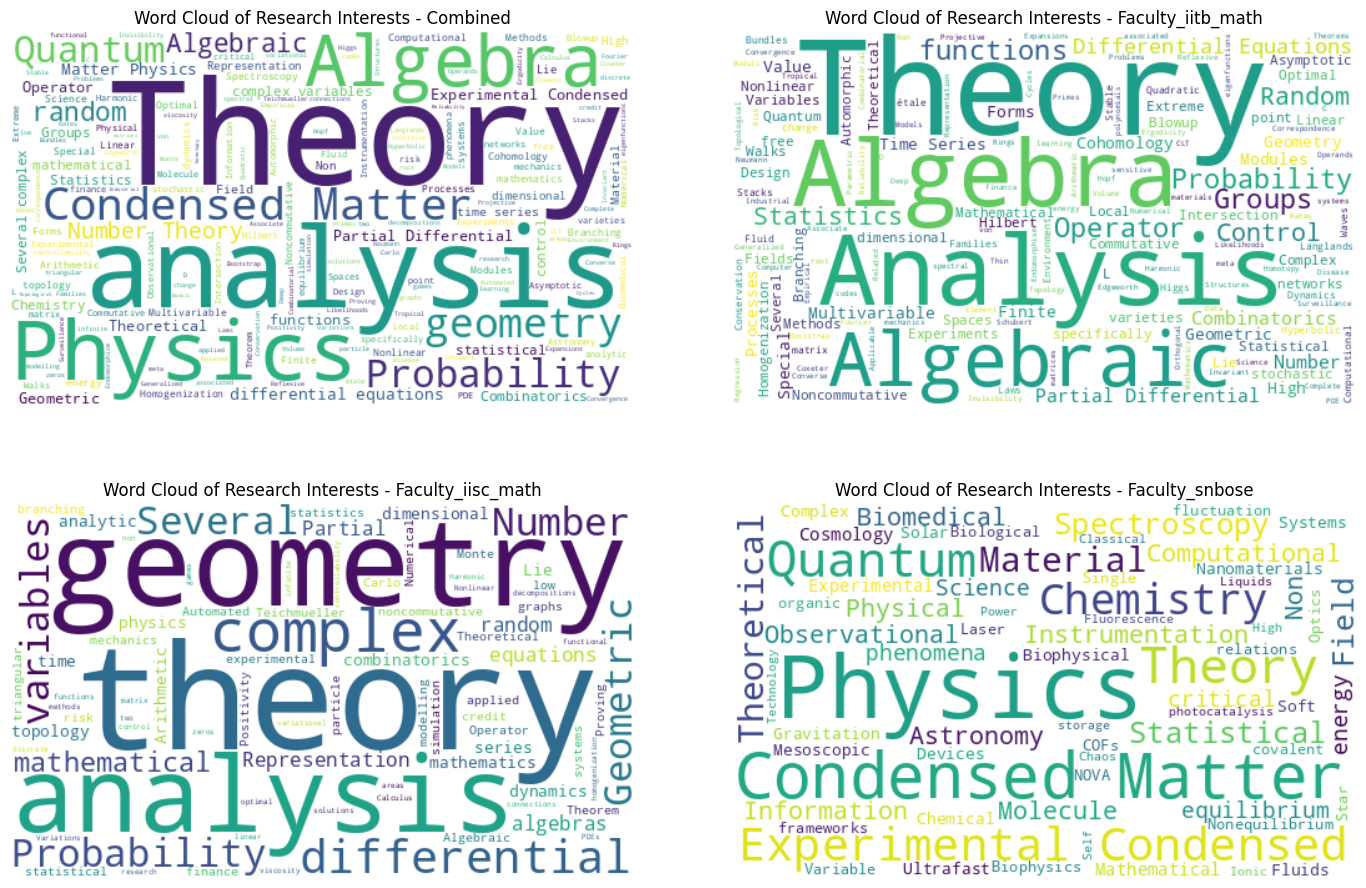

In [8]:
# Creating a word cloud for research keywords

# Connect to the SQLite database
conn = sqlite3.connect('Faculty_list.db')

# Create a 2x2 subplot grid for word clouds
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=4.0)

# Function to generate and plot word cloud for a specific table
def create_word_cloud(ax, table_name, title_prefix):
    query_research_keywords = f'''
    SELECT Research_Interests
    FROM {table_name}
    '''
    research_keywords_data = pd.read_sql(query_research_keywords, conn)
    research_keywords_text = ' '.join(research_keywords_data['Research_Interests'].dropna())

    # Generate word cloud
    wordcloud = WordCloud(width=500, height=300, background_color='white').generate(research_keywords_text)

    # Plotting
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud of Research Interests - {title_prefix}')

# Call the function for each individual table
create_word_cloud(axs[0, 0], 'faculty_combined_list', 'Combined')
create_word_cloud(axs[0, 1], 'Faculty_iitb_math', 'Faculty_iitb_math')
create_word_cloud(axs[1, 0], 'faculty_iisc_math', 'Faculty_iisc_math')
create_word_cloud(axs[1, 1], 'faculty_snbose', 'Faculty_snbose')

# Show the combined plot
plt.show()

# Close the database connection
conn.close()


## Number of faculty per Department

- The abbreviations could be checked from the main website for SN bose Institute, Kolkata.
- CMMP has the highest number of Faculty in SN Bose Institute.

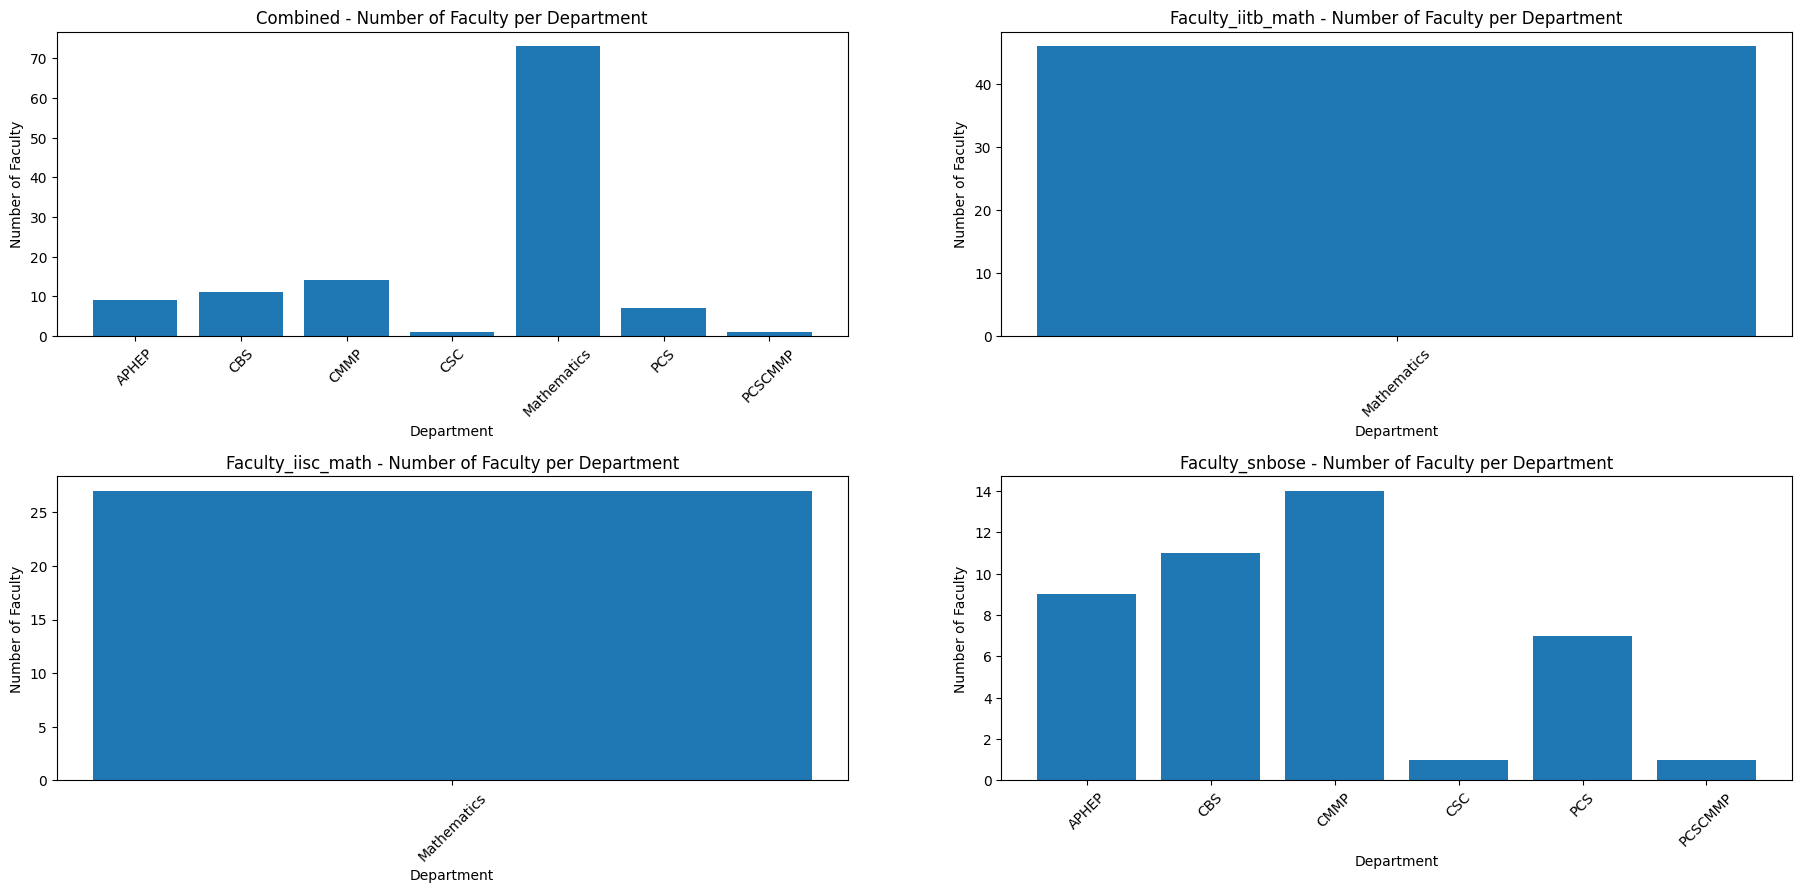

In [9]:
# Generating the plot for Number of faculty per department

# Connect to the SQLite database
conn = sqlite3.connect('Faculty_list.db')

# Function to create visualizations for an individual table
def create_visualizations_for_table(ax, table_name, title_prefix):
    # Query for Number of faculty per department
    query_department_faculty_count = f'''
    SELECT Department, COUNT(*) as FacultyCount
    FROM {table_name}
    GROUP BY Department
    '''
    department_faculty_data = pd.read_sql(query_department_faculty_count, conn)

    # Plotting
    ax.bar(department_faculty_data['Department'], department_faculty_data['FacultyCount'])
    ax.set_xlabel('Department')
    ax.set_ylabel('Number of Faculty')
    ax.set_title(f'{title_prefix} - Number of Faculty per Department')
    ax.tick_params(axis='x', rotation=45)  # Removed 'ha' parameter

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.tight_layout(pad=8.0)

# Call the function for each individual table
create_visualizations_for_table(axs[0, 0], 'faculty_combined_list', 'Combined')
create_visualizations_for_table(axs[0, 1], 'Faculty_iitb_math', 'Faculty_iitb_math')
create_visualizations_for_table(axs[1, 0], 'faculty_iisc_math', 'Faculty_iisc_math')
create_visualizations_for_table(axs[1, 1], 'faculty_snbose', 'Faculty_snbose')

# Show the combined plot
plt.show()

# Close the database connection
conn.close()


### Common Location/Institute for PhD amongst the faculty

- Even though the data is not cleaned much (for SN Bose, Kolkata), we can see a clear trend that most of the faculty have done their PhDs from TIFR Mumbai.

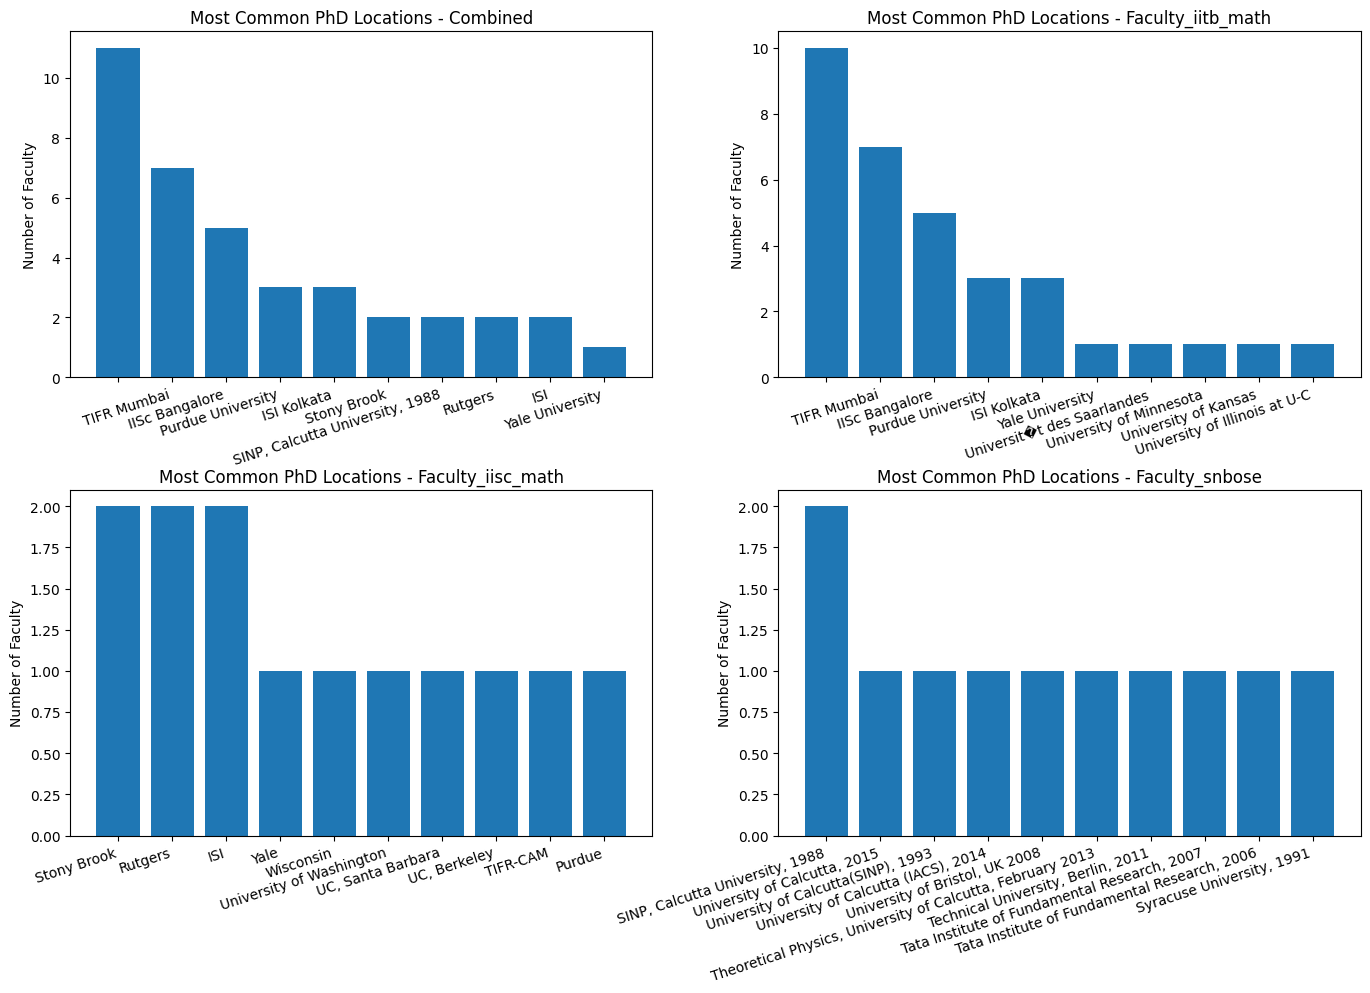

In [10]:
## Most common PhD locations plot

# Connect to the SQLite database
conn = sqlite3.connect('Faculty_list.db')

# Create a 2x2 subplot grid for most common PhD locations
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad = 6.0)

# Function to generate and plot most common PhD locations for a specific table
def create_phd_locations_plot(ax, table_name, title_prefix):
    query_phd_locations = f'''
    SELECT Location_of_PhD, COUNT(*) as PhdCount
    FROM {table_name}
    WHERE Location_of_PhD IS NOT NULL
    GROUP BY Location_of_PhD
    ORDER BY PhdCount DESC
    LIMIT 10
    '''
    phd_locations_data = pd.read_sql(query_phd_locations, conn)

    # Plotting
    ax.bar(phd_locations_data['Location_of_PhD'], phd_locations_data['PhdCount'])
    #ax.set_xlabel('PhD Location')
    ax.set_ylabel('Number of Faculty')
    ax.set_title(f'Most Common PhD Locations - {title_prefix}')

    # Set xticks and labels separately
    ax.set_xticks(range(len(phd_locations_data['Location_of_PhD'])))
    ax.set_xticklabels(phd_locations_data['Location_of_PhD'], rotation=18, ha='right')  # Adjust rotation here

# Call the function for each individual table
create_phd_locations_plot(axs[0, 0], 'faculty_combined_list', 'Combined')
create_phd_locations_plot(axs[0, 1], 'faculty_iitb_math', 'Faculty_iitb_math')
create_phd_locations_plot(axs[1, 0], 'faculty_iisc_math', 'Faculty_iisc_math')
create_phd_locations_plot(axs[1, 1], 'faculty_snbose', 'Faculty_snbose')

# Show the combined plot
plt.show()

# Close the database connection
conn.close()
